In [35]:
!pip install emoji --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import re
import os
import emoji
import spacy
import string
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline

In [37]:
from emoji import emojize

In [38]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [39]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Autos can charge 5% over base fee for app-base...,The Karnataka government has decided to let ap...,technology
1,Apple looks to buy Manchester United in $7 bil...,Technology giant Apple is interested in buying...,technology
2,"Binance not a Chinese company, I have to repea...",World's biggest crypto exchange Binance's CEO ...,technology
3,Twitter to grant amnesty to some suspended acc...,"Elon Musk has said that Twitter will offer ""ge...",technology
4,Twitter's Brussels office shuts down after 2 r...,Twitter has reportedly shut down its office in...,technology
5,Twitter fires engineers for 'unsatisfactory co...,Twitter has reportedly fired as many as 50 eng...,technology
6,It's not the end of crypto: Binance CEO on cur...,Binance's Changpeng Zhao took to Twitter to sh...,technology
7,"Post by former Twitter staff who was laid off,...",A post by a former Twitter employee made anony...,technology
8,Facebook-parent Meta added to Russian Justice ...,Facebook-owner Meta Platforms has been added t...,technology
9,Rival Samsung is Apple's largest supplier of i...,Samsung Display is expected to account for ove...,technology


In [40]:
news_df.to_csv('news_df_mentorama.csv')

In [41]:
news_df = pd.read_csv('news_df_mentorama.csv', index_col = 0)

In [46]:
def preprocess_text(text, remove_stop = True, stem_words = False, remove_mentions_hashtags = True):
    """
    eg:
    input: preprocess_text("@water #dream hi hello where are you going be there tomorrow happening happen happens",  
    stem_words = True) 
    output: ['tomorrow', 'happen', 'go', 'hello']
    """

    # Remove emojis
    emoji_pattern = re.compile("[" "\U0001F1E0-\U0001F6FF" "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)
    text = "".join([x for x in text if x not in emoji.EMOJI_DATA])

    if remove_mentions_hashtags:
        text = re.sub(r"@(\w+)", " ", text)
        text = re.sub(r"#(\w+)", " ", text)

    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    words = (''.join(nopunct)).split()

    if(remove_stop):
        words = [w for w in words if w not in ENGLISH_STOP_WORDS]
        words = [w for w in words if len(w) > 2]  # remove a,an,of etc.

    if(stem_words):
        stemmer = PorterStemmer()
        words = [stemmer.stem(w) for w in words]

    return list(words)

In [47]:
rows, cols = news_df.shape

In [48]:
#processando os textos
news_df['token'] = [preprocess_text(news_df["news_article"][row]) for row in range(rows)]

In [49]:
news_df.head()

,news_headline,news_article,news_category,token
0,Autos can charge 5% over base fee for app-base...,The Karnataka government has decided to let ap...,technology,"[karnataka, government, decided, let, app, bas..."
1,Apple looks to buy Manchester United in $7 bil...,Technology giant Apple is interested in buying...,technology,"[technology, giant, apple, interested, buying,..."
2,"Binance not a Chinese company, I have to repea...",World's biggest crypto exchange Binance's CEO ...,technology,"[world, biggest, crypto, exchange, binance, ce..."
3,Twitter to grant amnesty to some suspended acc...,"Elon Musk has said that Twitter will offer ""ge...",technology,"[elon, musk, said, twitter, offer, general, am..."
4,Twitter's Brussels office shuts down after 2 r...,Twitter has reportedly shut down its office in...,technology,"[twitter, reportedly, shut, office, brussels, ..."


In [50]:
# estanciando o spacy para ingles
!python -m spacy download en_core_web_md

2022-11-26 01:10:52.520516: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 178 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [52]:
# criando a variavel e definindo o spacy
nlp = spacy.load('en_core_web_md')

In [54]:
# definindo função que retorna os vetores para cada palavra:
def vec(s):
    return nlp.vocab[s].vector

In [55]:
# vetorizando os tokens
vec_size = 300
list_of_matrix = []
for corpus in news_df['token']:
    matrix = np.empty([len(corpus), vec_size])
    for idx, word in enumerate(corpus):
        matrix[idx,:] = vec(word)
    list_of_matrix.append(matrix)

In [56]:
final_feature_matrix = np.empty([rows, vec_size])

for row in range(rows):
    final_feature_matrix[row,:] = list_of_matrix[row].mean(axis = 0)

In [57]:
final_feature_matrix.shape

(74, 300)

In [58]:
# treinando kmeans
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=3, random_state=0).fit(final_feature_matrix)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [59]:
# printando resultado do kmeans
print(news_df["news_category"][kmeans.labels_ == 0]) 
print(news_df["news_category"][kmeans.labels_ == 1])
print(news_df["news_category"][kmeans.labels_ == 2])

25    sports
26    sports
27    sports
28    sports
29    sports
30    sports
31    sports
32    sports
33    sports
34    sports
35    sports
36    sports
37    sports
38    sports
39    sports
40    sports
41    sports
42    sports
43    sports
44    sports
45    sports
46    sports
47    sports
48    sports
49    sports
Name: news_category, dtype: object
0     technology
1     technology
2     technology
3     technology
4     technology
5     technology
6     technology
7     technology
9     technology
10    technology
11    technology
12    technology
13    technology
14    technology
15    technology
16    technology
17    technology
18    technology
19    technology
20    technology
21    technology
22    technology
23    technology
24    technology
53         world
66         world
Name: news_category, dtype: object
8     technology
50         world
51         world
52         world
54         world
55         world
56         world
57         world
58         world
59        

In [60]:
def get_closest(list_of_articles, article_position, df):
    article_vec = list_of_articles[article_position,:]
    other_vec = np.delete(list_of_articles, article_position, 0)
    from scipy import spatial
    A = [other_vec[row,:] for row in range(other_vec.shape[0])]
    tree = spatial.KDTree(A)
    closest_position = tree.query(article_vec)[1]
    print(df[article_position])
    print(df[closest_position])
    return tree.query(article_vec)[0], closest_position

In [61]:
# puxando o vetor 30 para ver o conteudo
get_closest(final_feature_matrix, 30, news_df["news_article"])

Shikhar Dhawan today became the eighth Indian player to score over 12,000 runs in List A cricket. Sachin Tendulkar (21,999) holds the record for scoring the most runs in List A among Indians. He's followed by Sourav Ganguly (15,622) and Rahul Dravid (15,271). Virat Kohli (13,786) comes fourth, followed by MS Dhoni (13,353), Mohammed Azharuddin (12,931) and Yuvraj Singh (12,663). 
All-rounder Moeen Ali said rival teams are trying to "copy" England's template in white-ball cricket because of their success in global competitions. He added that everyone wanted to copy Australia when they were winning everything in 1990s and now it's "us". England are the first team to hold both men's ODI and T20 World Cup trophies at the same time.


(12.076847099629568, 44)

In [63]:
# treinando pca com 4
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents
             ,columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

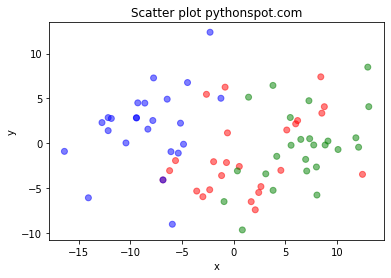

In [69]:
# Create data

x = principalDf['principal component 1'] + principalDf['principal component 2']
y = principalDf['principal component 3'] + principalDf['principal component 4']

# Plot

colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [70]:
principalComponents

array([[-2.24158886e+00,  8.25456893e+00,  4.15616825e-01,
         1.74066004e+00],
       [ 4.99206673e-01,  4.64907856e+00,  1.90032627e-01,
         1.27969924e+00],
       [-1.68467146e+00,  2.23358208e+00, -1.56057295e+00,
        -1.04103650e+00],
       [-1.93413817e+00, -1.64542880e+00, -4.13540159e+00,
        -1.21236518e+00],
       [-4.51202782e+00, -1.12165371e+00, -3.11486267e+00,
         1.16853462e+00],
       [-5.23463940e+00,  2.25157639e+00, -4.08771213e+00,
        -1.88935070e+00],
       [-3.55909031e-01,  6.55417803e+00,  1.37786243e+00,
         1.14647456e+00],
       [-2.44466631e+00,  1.27578459e+00, -5.20778393e+00,
         1.59084074e+00],
       [-7.22971300e+00,  3.81104384e-01, -2.87405565e-01,
        -3.81561087e+00],
       [-1.58276892e+00,  1.00291542e+01,  2.02545495e+00,
         5.37770664e+00],
       [-2.96734186e+00,  7.54276615e+00, -2.28788820e+00,
        -7.46206632e-01],
       [-7.08982368e+00,  8.83508799e-01, -2.96739474e+00,
      

In [71]:
# importando lib
from sklearn.manifold import MDS

In [72]:
# definindo parametros e treinando modelo
mds = MDS(n_components=2)
mds.fit(final_feature_matrix)

MDS()

In [73]:
principalComponents = mds.fit_transform(final_feature_matrix)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

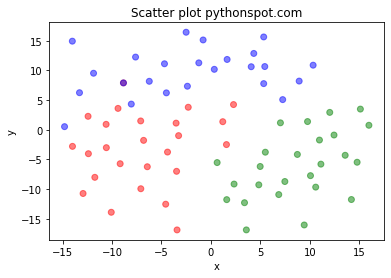

In [74]:
x = principalDf['principal component 1']
y = principalDf['principal component 2']

# Plot
colors = {'technology':'red', 'world':'blue', 'sports':'green'}
plt.scatter(x, y, alpha=0.5, c = news_df['news_category'].apply(lambda x: colors[x]))
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

O Modelo MDS demonstrou melhor clusterização.